### Autorzy
Wojciech Jąkalski & Krzysztof Zaucha

# Generowanie przykladowego szeregu

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sb
sb.set_style('darkgrid')

import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
import random
from statsmodels.tsa.stattools import pacf
from statsmodels.stats.diagnostic import het_arch
import statsmodels.api as sm

# Wstęp

In [2]:
dane_txt = open('daily-min-temperatures.txt')
f = dane_txt.readlines()
dane = []
for x in f[1:]:
    dane.append(float(x[13:-1]))
n = len(dane)
n

3650

(-2.2328784231507717,
 0.19452957157796236,
 18,
 701,
 {'1%': -3.4397129207385357,
  '5%': -2.8656718422599923,
  '10%': -2.568970295481694},
 3293.730803227182)

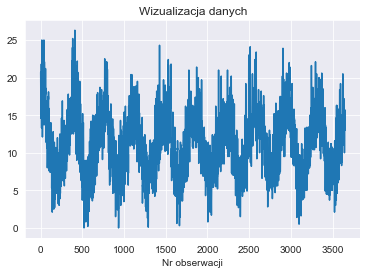

In [24]:
plt.plot(dane)
plt.title("Wizualizacja danych")
plt.xlabel("Nr obserwacji")
adfuller(dane[:720])

# Przygotowanie do analizy

C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

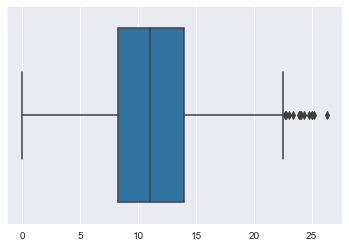

In [4]:
sb.boxplot(dane)

<AxesSubplot:ylabel='Count'>

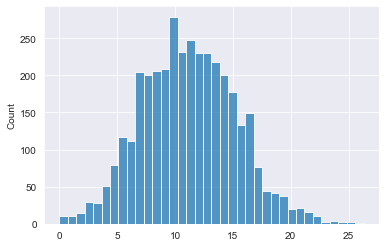

In [5]:
sb.histplot(dane)

In [6]:
dane_tren = dane[:-365]
dane_test = dane[-365:]
len(dane_tren)

3285

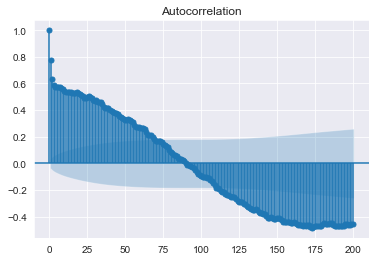

In [7]:
acf_plot = plot_acf(dane_tren, lags = 200, alpha=0.05)
plt.show()

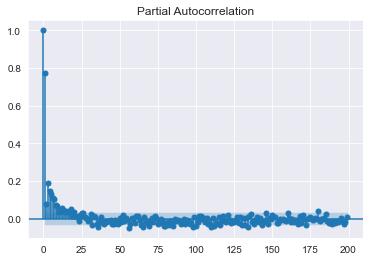

In [8]:
pacf_plot = plot_pacf(dane_tren, lags=199, method='ywm')
plt.show()

In [9]:
pacf_dane = pacf(dane_tren, 199, method='ywm')
# Augmented Dicker-Fuller test na stacjonarność szeregu, druga liczba to p-wartość

adfuller(dane_tren)

(-4.345532153010097,
 0.00037012247772345977,
 19,
 3265,
 {'1%': -3.4323544253126586,
  '5%': -2.8624256356937496,
  '10%': -2.5672414426759285},
 15013.20768211782)

C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([-3.24615547e-05,  1.11764394e+01])

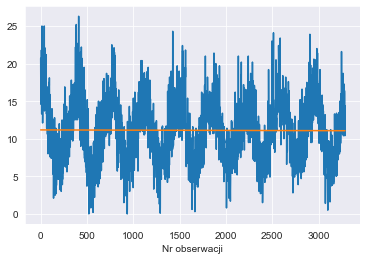

In [10]:
# Dopasowanie trendu
lin = np.linspace(1, len(dane_tren), len(dane_tren))
w = np.polyfit(lin, dane_tren, 1)
y = np.polyval(w, np.arange(1, len(dane_tren)+1, 1))

# Usunięcie trendu
dane_tren_1 = dane_tren - y
acf_dane_1 = acf(dane_tren_1, nlags=199)
plt.plot(dane_tren)
plt.plot(y)
plt.xlabel("Nr obserwacji")
w

Text(0.5, 0, 'Nr obserwacji')

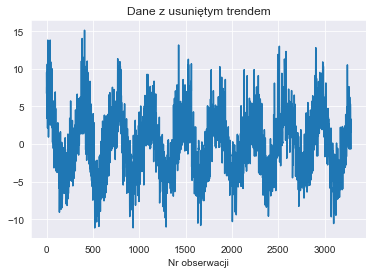

In [11]:
plt.plot(dane_tren_1)
plt.title("Dane z usuniętym trendem")
plt.xlabel("Nr obserwacji")

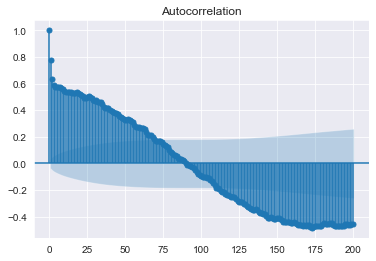

In [12]:
plot_acf(dane_tren_1, lags=200)
plt.show()

In [13]:
# Różnicowanie

rozn1 = [dane_tren[i] - dane_tren[i-1] for i in range(1, len(dane_tren))]
rozn2 = [dane_tren[i] - 2 * dane_tren[i-1] + dane_tren[i-2] for i in range(2, len(dane_tren))]

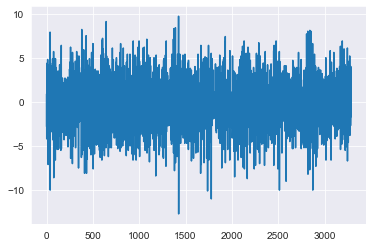

In [14]:
plt.plot(rozn1)

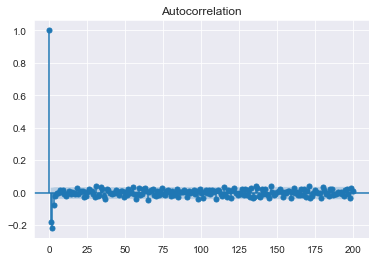

In [15]:
plot_acf(rozn1, lags=200)
plt.show()

[365.67974533  -4.22262073  -9.81204347]


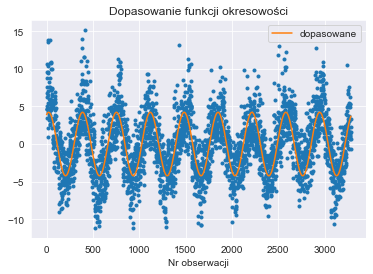

In [16]:
# Usuwanie sezonowości
N = len(dane_tren_1)
t = np.linspace(0, N, N)
data = dane_tren_1

guess_freq = 350
guess_amplitude = 4
guess_phase = -11
guess_offset = np.mean(data)

p0=[guess_freq, guess_amplitude, guess_phase]

# create the function we want to fit
def my_sin(x, freq, amplitude, phase):
    return np.cos(x * 2*np.pi / freq + phase) * amplitude

# now do the fit
fit = curve_fit(my_sin, t, data, p0=p0)


# recreate the fitted curve using the optimized parameters
data_fit = my_sin(t, *fit[0])
print(fit[0])

plt.plot(data, '.')
plt.plot(data_fit, label='dopasowane')
plt.title('Dopasowanie funkcji okresowości')
plt.xlabel("Nr obserwacji")
plt.legend()
plt.show()

In [17]:
dane_tren_2 = dane_tren_1 - data_fit

In [19]:
adfuller(dane_tren_2, autolag='AIC'), adfuller(dane, autolag='AIC')

((-16.684377272471718,
  1.5069299097341598e-29,
  6,
  3278,
  {'1%': -3.4323464698589774,
   '5%': -2.8624221218326817,
   '10%': -2.5672395719722254},
  14873.957700322619),
 (-4.444804924611681,
  0.00024708263003611787,
  20,
  3629,
  {'1%': -3.4321532327220154,
   '5%': -2.862336767636517,
   '10%': -2.56719413172842},
  16642.822304301197))

Text(0.5, 0, 'Nr obserwacji')

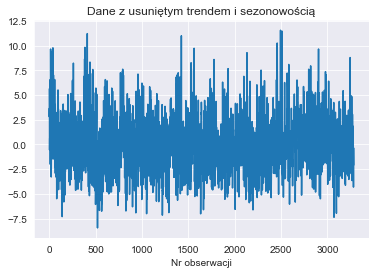

In [18]:
plt.plot(dane_tren_2)
plt.title("Dane z usuniętym trendem i sezonowością")
plt.xlabel("Nr obserwacji")

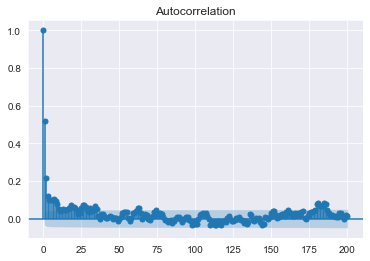

In [19]:
plot_acf(dane_tren_2, lags=200)
plt.show()

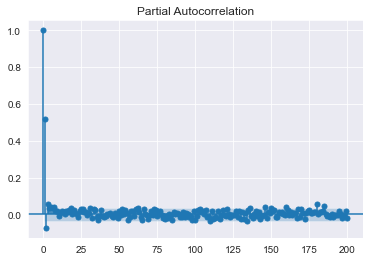

In [20]:
plot_pacf(dane_tren_2, lags=200)
plt.show()

In [21]:
adfuller(dane_tren_2)

(-16.684377272471718,
 1.5069299097341598e-29,
 6,
 3278,
 {'1%': -3.4323464698589774,
  '5%': -2.8624221218326817,
  '10%': -2.5672395719722254},
 14873.957700322619)

# Modelowanie przy pomocy ARMA

In [22]:
# znalezienie rzędu modelu (p, q) za pomocą kryteriów informacyjnych

df = pd.DataFrame()
pp = []
qq = []
BIC = [] # Bayesowskie kryterium informacyjne
AIC = [] # Kryterium Informacyjne Akkaikego
max_p, max_q = 5, 5

for p in range(max_p):
    for q in range(max_q):
        model = ARIMA(dane_tren_2, order = (p, 0, q))
        model_fit = model.fit()
        pp.append(p)
        qq.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
df['p'] = pp
df['q'] = qq
df['AIC'] = AIC
df['BIC'] = BIC

C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Kzysztof Zaucha\

In [23]:
df.sort_values(by='AIC')

,p,q,AIC,BIC
12,2,2,15013.182344,15049.765076
16,3,1,15013.724959,15050.307691
21,4,1,15014.905395,15057.585248
9,1,4,15014.915852,15057.595706
17,3,2,15014.941100,15057.620954
8,1,3,15015.169318,15051.752050
14,2,4,15016.912028,15065.689004
22,4,2,15016.947640,15065.724615
18,3,3,15017.157657,15065.934632
13,2,3,15018.511618,15061.191471


In [24]:
df.sort_values(by='BIC')

,p,q,AIC,BIC
12,2,2,15013.182344,15049.765076
16,3,1,15013.724959,15050.307691
8,1,3,15015.169318,15051.752050
21,4,1,15014.905395,15057.585248
9,1,4,15014.915852,15057.595706
17,3,2,15014.941100,15057.620954
13,2,3,15018.511618,15061.191471
14,2,4,15016.912028,15065.689004
22,4,2,15016.947640,15065.724615
18,3,3,15017.157657,15065.934632


In [25]:
final_model = ARIMA(dane_tren_2, order=(2, 0, 2)).fit()
final_model.summary()

C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3285
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7500.591
Date:                Wed, 08 Feb 2023   AIC                          15013.182
Time:                        18:55:29   BIC                          15049.765
Sample:                             0   HQIC                         15026.280
                               - 3285                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0168      0.145      0.115      0.908      -0.268       0.301
ar.L1          1.2613      0.045     28.171      0.000       1.174       1.349
ar.L2         -0.2833      0.039     -7.242      0.000      -0.360      -0.207
ma.L1         -0.7110      0.046    -15.626      0.000      -0.800      -0.622
ma.L2         -0.2136      0.033     -6.462      0.000      -0.278      -0.149
sigma2         5.6325      0.134     41.945      0.000       5.369       5.896
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                10.12
Prob(Q):                              1.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.85   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(array([0.00352481, 0.00264361, 0.00264361, 0.00264361, 0.00704962,
        0.01233683, 0.00969322, 0.01762404, 0.03524808, 0.04141649,
        0.0458225 , 0.06785255, 0.07754577, 0.0898826 , 0.10486303,
        0.11808106, 0.11279385, 0.1348239 , 0.13746751, 0.15861636,
        0.15156674, 0.17183438, 0.16919078, 0.16919078, 0.18505241,
        0.16214116, 0.12777429, 0.11367505, 0.10133823, 0.08107058,
        0.06785255, 0.04229769, 0.03524808, 0.02114885, 0.02731726,
        0.02291125, 0.01057442, 0.01674284, 0.01057442, 0.00440601,
        0.00440601, 0.00440601, 0.00616841, 0.0017624 , 0.0008812 ,
        0.0017624 , 0.        , 0.        , 0.        , 0.0008812 ]),
 array([-7.42531301, -7.07985986, -6.7344067 , -6.38895354, -6.04350039,
        -5.69804723, -5.35259407, -5.00714092, -4.66168776, -4.3162346 ,
        -3.97078145, -3.62532829, -3.27987513, -2.93442198, -2.58896882,
        -2.24351566, -1.89806251, -1.55260935, -1.20715619, -0.86170304,
        -0.51624988, -0.17

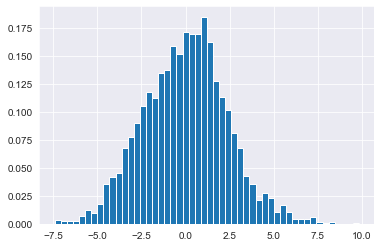

In [26]:
plt.hist(final_model.resid, density=True, bins=50)

In [27]:
residuals = final_model.resid
params = final_model.params
params[1], params[2], params[3], params[4], params[5]

(1.2613131639293822,
 -0.2832530232039668,
 -0.7110196610112948,
 -0.21356189617335192,
 5.632509388290951)

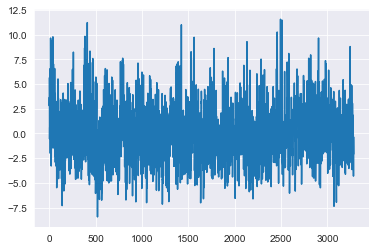

In [28]:
plt.plot(dane_tren_2)

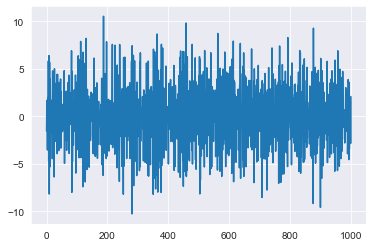

In [29]:
ar2 = np.array([1,.2613131639293822,params[2]])
ma2 = np.array([1,params[3],params[4]])
ARMA2 = ArmaProcess(ar2, ma2).generate_sample(nsample=1000, scale = np.sqrt(params[5]))
plt.plot(ARMA2)

In [30]:
def data_func(n=1000, fi1=params[1], fi2 =params[2], theta1 =params[3], theta2 = params[4], sigma=np.sqrt(params[5])):
    Yt = []
    Z_t = st.norm.rvs(loc = 0, scale = sigma, size = n)
    Xt = [st.norm.rvs(loc = 0, scale = sigma), st.norm.rvs(loc = 0, scale = sigma)]
    for i in range(n-2):
        Xt.append(fi1*Xt[-1] + fi2*Xt[-2] + Z_t[i+2] + theta1*Z_t[i+1] + theta2*Z_t[i])
    return Xt
def autocovariance(x,h):
    n = len(x)
    meanx = np.mean(x)
    return 1/n * sum([(x[i] - meanx)*(x[i+h] - meanx) for i in range(n - h)])
def autocorr(x,h):
    return autocovariance(x,h)/autocovariance(x,0)
def Cov(h,fi = 0.2, sigma = np.sqrt(0.4)):
    return sigma**2*fi**(abs(h))/(1 - fi**2)
def Cor(h,fi = 0.2, sigma = np.sqrt(0.4)):
    return fi**(abs(h))
def PACF_func(h,theta = 0.5):
    if h==0:
        return 1
    else:
        return -(-theta)**h/sum([theta**(2*i) for  i in range(h+1)])

In [31]:
data = data_func()

In [32]:
#def data_func(n=1000):
    #ar2 = np.array([1,params[1],params[2]])
    #ma2 = np.array([1,params[3],params[4]])
    #ARMA2 = ArmaProcess(ar2, ma2).generate_sample(nsample=n, scale = np.sqrt(params[5]))
    #return ARMA2

# Empiryczne przedziały ufności ACF PACF

In [180]:
def ACF(m = 10000, alpha= 0.05, ran=51):
    h_tab = np.arange(0,ran)
    rang = len(h_tab)
    #thcor = Cor(h_tab)
    BIGcor = []
    cora_int = []
    corb_int = []
    for i in range(m):
        cor = []
        data = data_func()
        for h in h_tab:
            cor.append(autocorr(data, h))
        BIGcor.append(cor)
    for i in range(rang):
        cora_int.append(sorted([BIGcor[j][i] for j in range(m)])[int(m*(alpha) - 1)])
        corb_int.append(sorted([BIGcor[j][i] for j in range(m)])[int(m*(1-alpha) - 1)])
    fig, ax1 = plt.subplots(figsize = (15,15))
    ax1.set_title("Autokorelacja", fontsize = 25)
    ax1.plot(h_tab, cora_int, 'b', label = "Przedziały ufności")
    ax1.plot(h_tab, corb_int, 'b')
    ax1.scatter(h_tab, np.array([autocorr(dane_tren_2,h) for h in h_tab]), label = "ACF danych rzeczywistych", color = "red")
    #ax1.scatter(h_tab, thcor, label = "Teoretyczna")
    ax1.legend()
    fig.savefig("ACF.jpg")
    
def PACF(m=10000, alpha=0.05, ran = 51):
    h_tab = np.arange(0,ran)
    BIGcor = []
    cora_int = []
    corb_int = []
    #thcor = [PACF_func(h_tab[i]) for i in range(len(h_tab))]
    for i in range(m):
        data = data_func()
        BIGcor.append(pacf(data,ran - 1))
    for i in range(len(h_tab)):
        cora_int.append(sorted([BIGcor[j][i] for j in range(m)])[int(m*(alpha) - 1)])
        corb_int.append(sorted([BIGcor[j][i] for j in range(m)])[int(m*(1-alpha) - 1)])
    fig, ax2 = plt.subplots(figsize = (20,20))
    ax2.set_title("Częściowa autokorelacja", fontsize = 25)
    ax2.plot(h_tab, cora_int, 'b', label = "Przedziały ufności")
    ax2.plot(h_tab, corb_int, 'b')
    ax2.scatter(h_tab,  pacf(dane_tren_2, ran-1), label =  "PACF danych rzeczywistych", color = "red")
    #ax2.scatter(h_tab, thcor, label = "Teoretyczna")
    ax2.legend()
    fig.savefig("PACF.jpg")

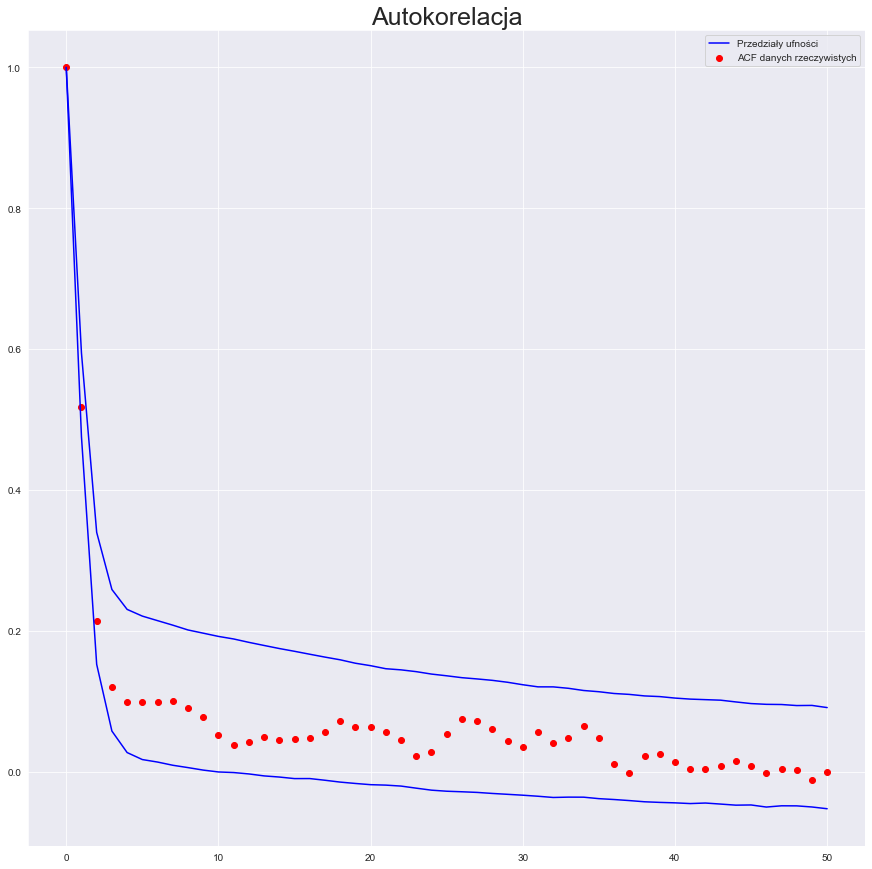

In [181]:
ACF()

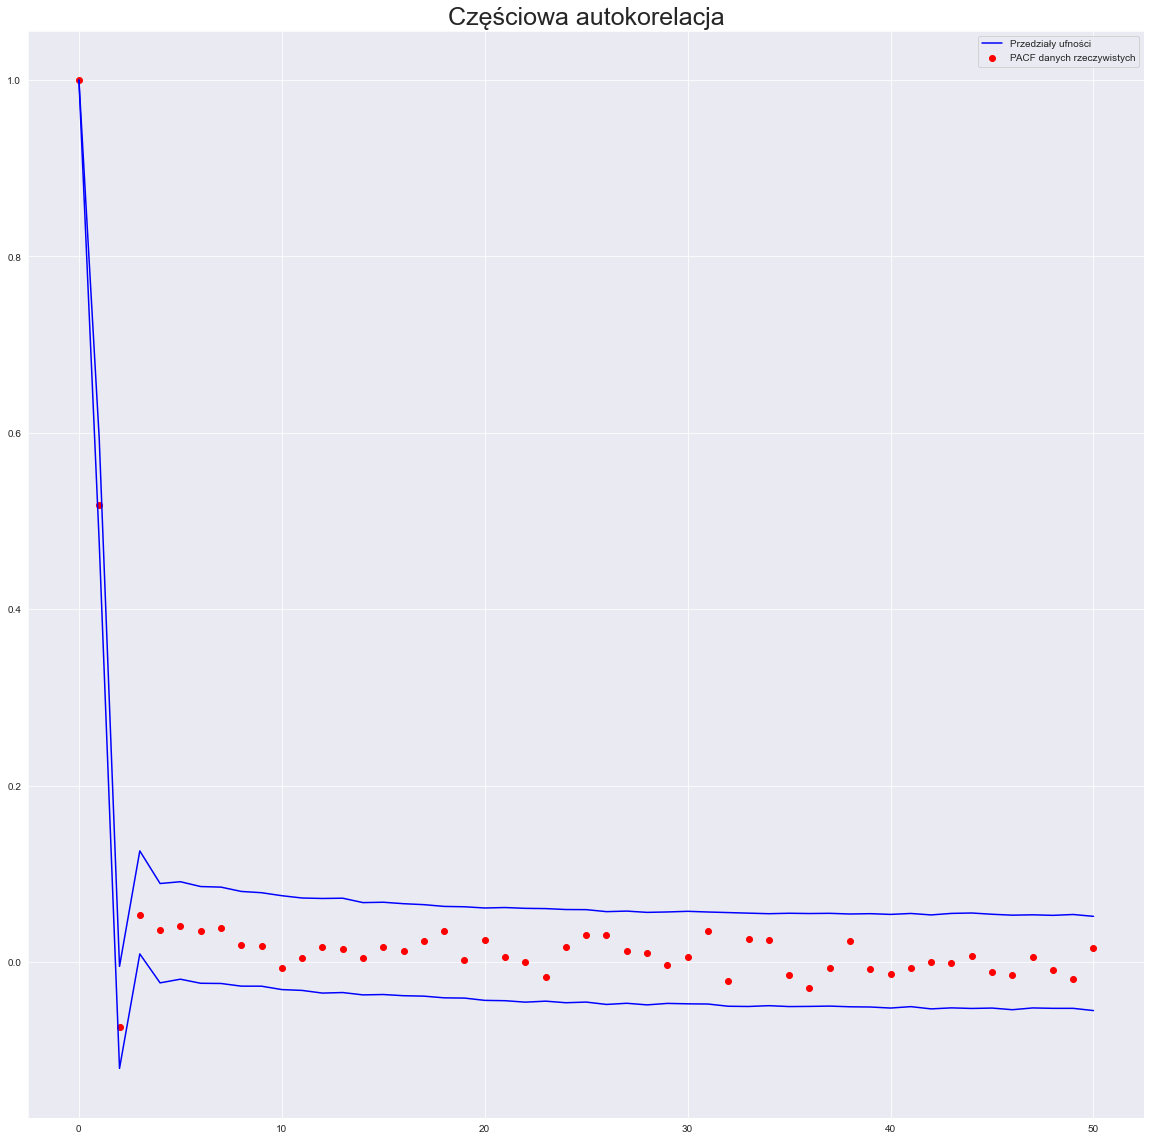

In [182]:
PACF()

# Linie kwantylowe porównane z trajektorią

[80.0, 58.06, 37.64, 20.42]

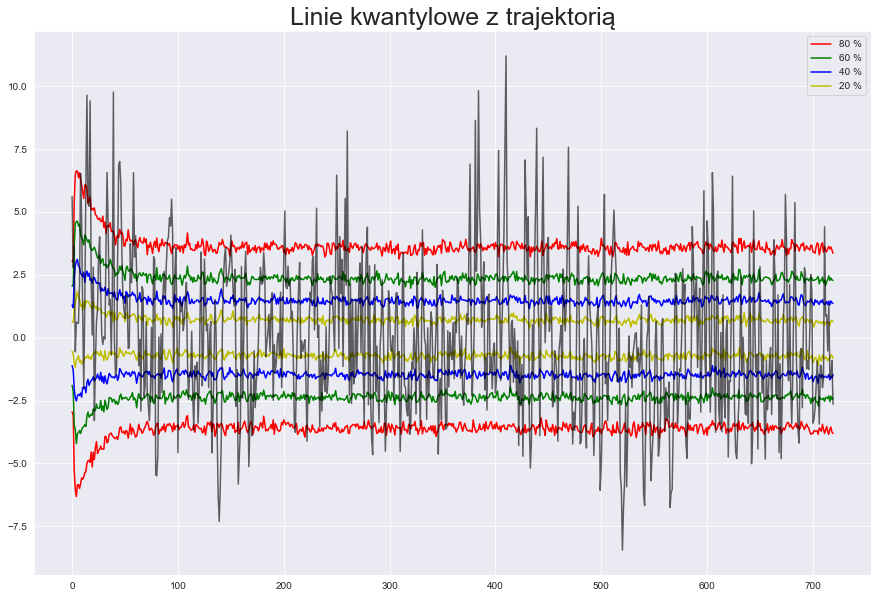

In [33]:
def Quantile(data, n = 1000, t_ran= 720):
    t = np.arange(0,t_ran)
    alphas = [10,20,30,40]
    colors = ['r', 'g', 'b', 'y']
    labels = [str(100 - 2*alpha) + " %" for alpha in alphas]
    quantileArr = np.zeros((n,t_ran))
    alphaArr = np.zeros((8,t_ran))
    for i in range(n):
        quantileArr[i,:] = data_func(t_ran)
    for i in range(t_ran):
        quantileArr[:,i] = np.sort(quantileArr[:,i])
    for alpha in range(len(alphas)):
        alphaArr[2*alpha, :] = np.array([quantileArr[:,j][n - alphas[alpha]*int(n/100) - 1] for j in range(t_ran)])
        alphaArr[2*alpha + 1, :] = np.array([quantileArr[:,j][alphas[alpha]*int(n/100) -1] for j in range(t_ran)])
    fig, ax = plt.subplots( figsize = (15,10))
    for i in range(len(alphas)):
        ax.plot(t, alphaArr[int(2*i), :] ,colors[i], label = labels[i])
        ax.plot(t, alphaArr[int(2*i) + 1, :] ,colors[i])
    xs = data
    ax.plot(t, xs,'k', alpha=0.6)
    ax.legend()
    ax.set_title("Linie kwantylowe z trajektorią", fontsize = 25)
    percent_tab = []
    for i in range(4):
        percent = 0
        for j in t:
            if alphaArr[int(2*i)+1, j] <= xs[j] <= alphaArr[int(2*i), j]:
                percent += 1
        percent_tab.append(round(percent/t_ran *100, 2))
    fig.savefig("Quantile.jpg")
    return percent_tab
per = Quantile(dane_tren_2[0:720])
per

# Prognoza dla przyszłych danych

In [240]:
lin = np.arange(3285, 3650)

def trend(t):
    return my_sin(t, *fit[0]) -3.24615547e-05*t +  1.11764394e+01 

def QuantileFuture(n = 10000, t_ran= 3650):
    t = np.arange(0,t_ran)
    alphas = [1,20,30,40]
    colors = ['r', 'g', 'b', 'y']
    labels = [str(100 - 2*alpha) + " %" for alpha in alphas]
    quantileArr = np.zeros((n,t_ran))
    alphaArr = np.zeros((8,t_ran))
    for i in range(n):
        quantileArr[i,:] = data_func(t_ran)
    for i in range(t_ran):
        quantileArr[:,i] = np.sort(quantileArr[:,i])
    for alpha in range(len(alphas)):
        alphaArr[2*alpha, :] = np.array([quantileArr[:,j][n - alphas[alpha]*int(n/100) - 1] for j in range(t_ran)])
        alphaArr[2*alpha + 1, :] = np.array([quantileArr[:,j][alphas[alpha]*int(n/100) -1] for j in range(t_ran)])
    return alphaArr

quants = QuantileFuture()

365

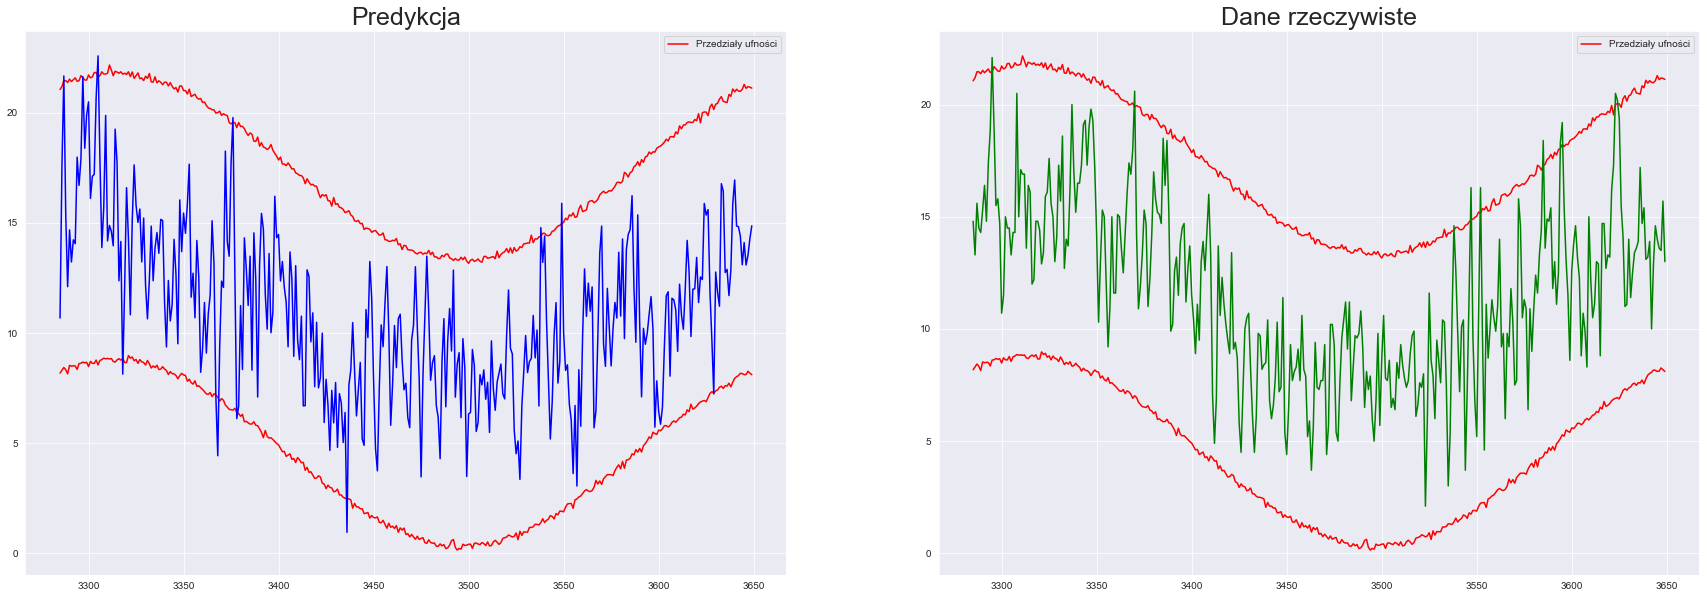

In [267]:
Qua = np.array([quants[i][3285:] for i in range(8)])
datareal = dane[3285:]
backdata = dane_tren_2[2920:3285]
timeseries = data_func(3650)
fig6, (ax9, ax10) = plt.subplots(1,2,figsize = (30,10))
ax9.plot(lin, Qua[0] + trend(lin), 'r', label = 'Przedziały ufności')
ax9.plot(lin, Qua[1] + trend(lin), 'r')
ax9.plot(lin, timeseries[3285:] + trend(lin), 'b')
ax9.set_title("Predykcja", fontsize = 25)
ax9.legend()
ax10.plot(lin, Qua[0] + trend(lin), 'r', label = "Przedziały ufności")
ax10.plot(lin, Qua[1] + trend(lin), 'r')
ax10.plot(lin, datareal, 'g')
ax10.set_title("Dane rzeczywiste", fontsize = 25)
ax10.legend()
fig6.savefig("predts.jpg")
len(Qua[1])

# Sprawdzenie założeń

(-0.005142731758449566,
 Ttest_1sampResult(statistic=-0.12414631717550707, pvalue=0.9012070238205676))

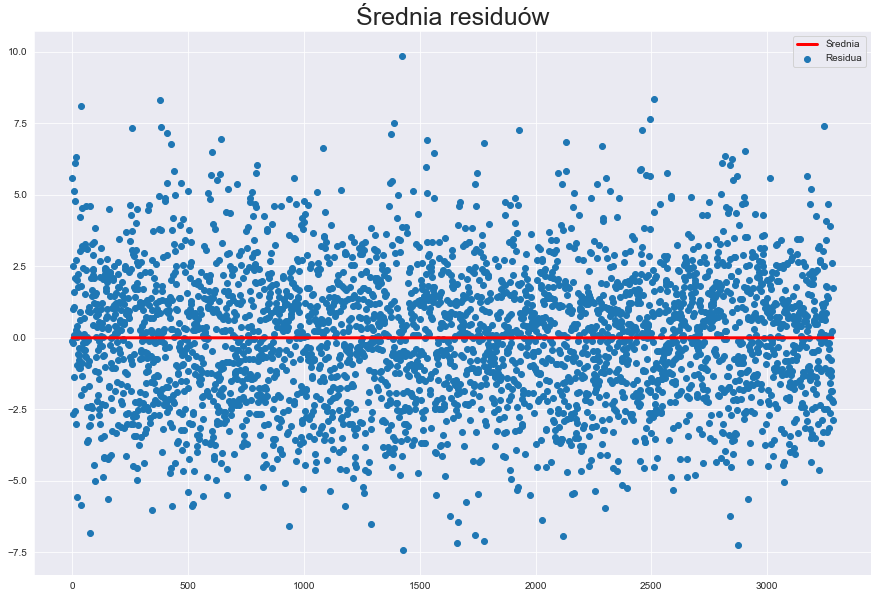

In [201]:
data = residuals
fig1, ax1 = plt.subplots(figsize = (15,10))
xs = np.arange(0,len(data))
ax1.scatter(xs, data, label = "Residua")
ax1.plot(xs, np.array([np.mean(data) for i in range(3285)]), 'r', linewidth = 3, label = "Średnia")
ax1.legend()
ax1.set_title("Średnia residuów", fontsize = 25)
fig1.savefig("Meanresid.jpg")
np.mean(data), st.ttest_1samp(data, 0)

C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3621: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\numpy\core\_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(5.635380072621818, LeveneResult(statistic=nan, pvalue=nan))

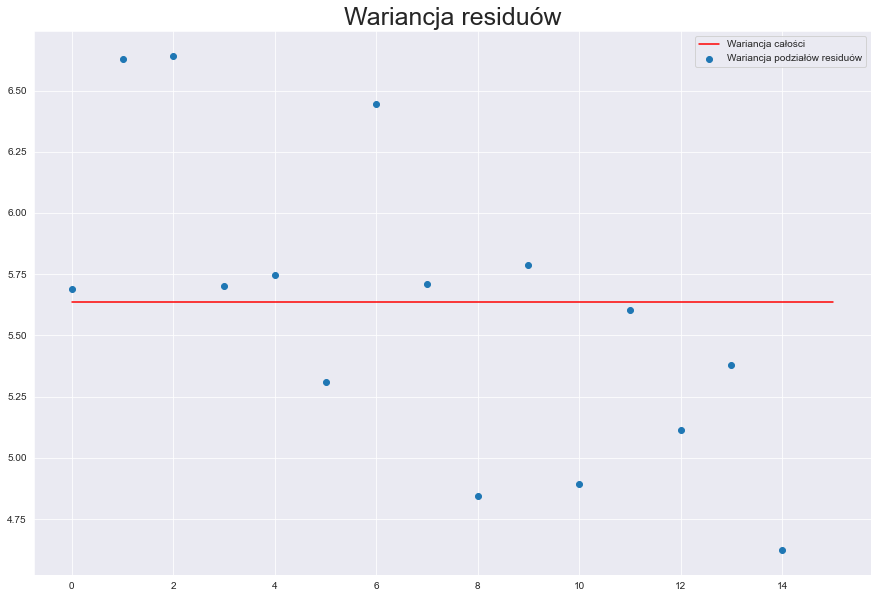

In [199]:
#data = st.norm.rvs(loc=0, scale = np.sqrt(5.635), size = 3285)
fig2, ax2 = plt.subplots(figsize = (15,10))
vartab = [np.var(data[219*i:int(219*(i+1))]) for i in range(16)]
levene_tab = [data[219*i:int(219*(i+1))] for i in range(16)]
ax2.scatter(np.arange(0,16), vartab, label = "Wariancja podziałów residuów")
ax2.plot(np.arange(0,16), np.array([np.var(data) for i in range(16)]), 'r', label="Wariancja całości")
ax2.set_title("Wariancja residuów", fontsize = 25)
ax2.legend()
fig2.savefig("Varresid.jpg")
np.var(data), st.levene(*levene_tab)#, het_arch(np.array(data))

In [112]:
def ecdf(X):
    xs = np.sort(X)
    ys = np.arange(1, len(xs) + 1)/float(len(xs))
    return xs, ys

C:\Users\Kzysztof Zaucha\anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


(array([0.50055038]), array([0.99210313]))

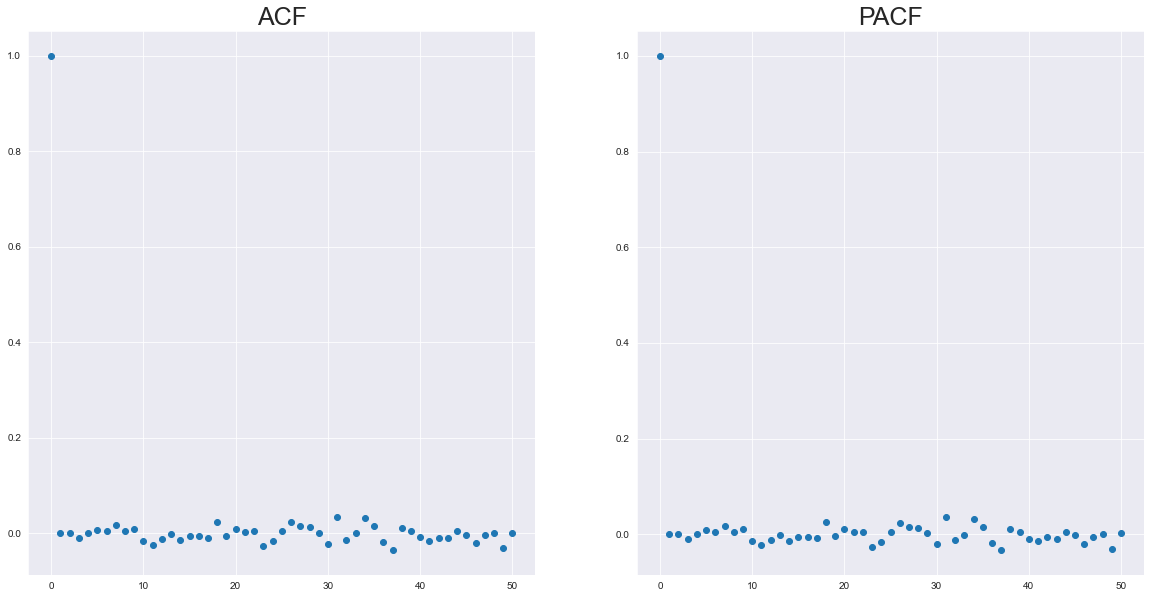

In [176]:
fig3, (ax3, ax4) = plt.subplots(1,2,figsize = (20,10))
h_tab = np.arange(0,51)
cor = np.array([autocorr(data, i) for i in range(51)])
ax3.scatter(h_tab, cor)
ax3.set_title("ACF", fontsize = 25)
ax4.scatter(h_tab, pacf(data,50))
ax4.set_title("PACF", fontsize = 25)
fig3.savefig("(P)ACFresid")
sm.stats.acorr_ljungbox( data, lags = [5])

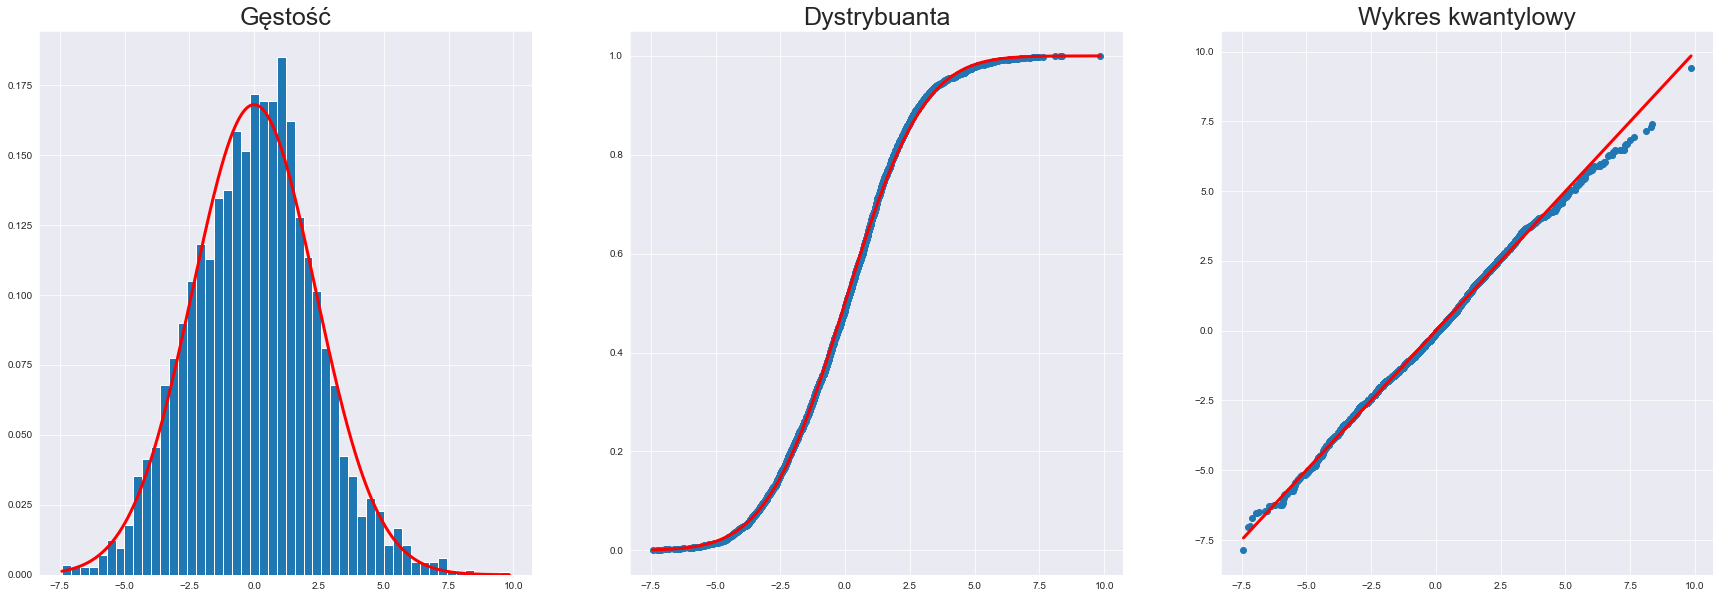

In [174]:
xs, ys = ecdf(residuals)
fig4, (ax5, ax6, ax7) = plt.subplots(1,3, figsize = (30,10))
lin = np.linspace(min(residuals), max(residuals), len(residuals))
ax5.hist(residuals, bins = 50, density = True)
ax5.plot(lin, st.norm.pdf(lin, loc = np.mean(residuals), scale = np.var(residuals)**(1/2)), 'r', linewidth = 3)
ax5.set_title("Gęstość", fontsize = 25)
ax6.scatter(xs, ys)
ax6.plot(lin, st.norm.cdf(lin, loc = np.mean(residuals), scale = np.var(residuals)**(1/2)), 'r', linewidth = 3)
ax6.set_title("Dystrybuanta", fontsize = 25)
ax7.plot(lin, lin, 'r', linewidth = 3)
ax7.scatter(np.sort(residuals), np.sort(st.norm.rvs(loc = 0, scale = np.var(residuals)**(1/2), size = len(ys))))
ax7.set_title("Wykres kwantylowy", fontsize = 25)
fig4.savefig("normality.jpg")


In [209]:
from statsmodels.stats.diagnostic import lilliefors
st.shapiro(data), st.kstest((data - np.mean(data))/(np.sqrt(np.var(data))), st.norm.cdf), st.jarque_bera(data)


(ShapiroResult(statistic=0.9977393746376038, pvalue=0.00010094899334944785),
 KstestResult(statistic=0.014462244169805571, pvalue=0.49338448778149924),
 Jarque_beraResult(statistic=10.334725311382702, pvalue=0.005699580771584278))

In [207]:
data = np.array(data)
(data - np.mean(data))/(np.sqrt(len(data)*np.var(data)))

array([ 0.04117364, -0.00094834,  0.01841294, ..., -0.0210892 ,
        0.01283894, -0.01643539])

In [153]:
lilliefors(data)

(0.01449860738126807, 0.09740933255526059)

In [172]:
t = st.norm.rvs(loc = 1, scale = 1, size = 1000) 
xs, ys = ecdf(t)
#st.kstest(t, st.norm.cdf)
lilliefors(t)

(0.017029408199832174, 0.7603306542447585)

In [143]:
st.shapiro(t)

ShapiroResult(statistic=0.9969086647033691, pvalue=0.04912280663847923)

In [198]:
r = st.norm.rvs(loc = 0, scale = 1, size = 1000)
rt = [r[:200], r[200:400], r[400:600], r[600:800], r[800:]]
st.levene(*rt)

LeveneResult(statistic=2.379117812737138, pvalue=0.050144159378717475)